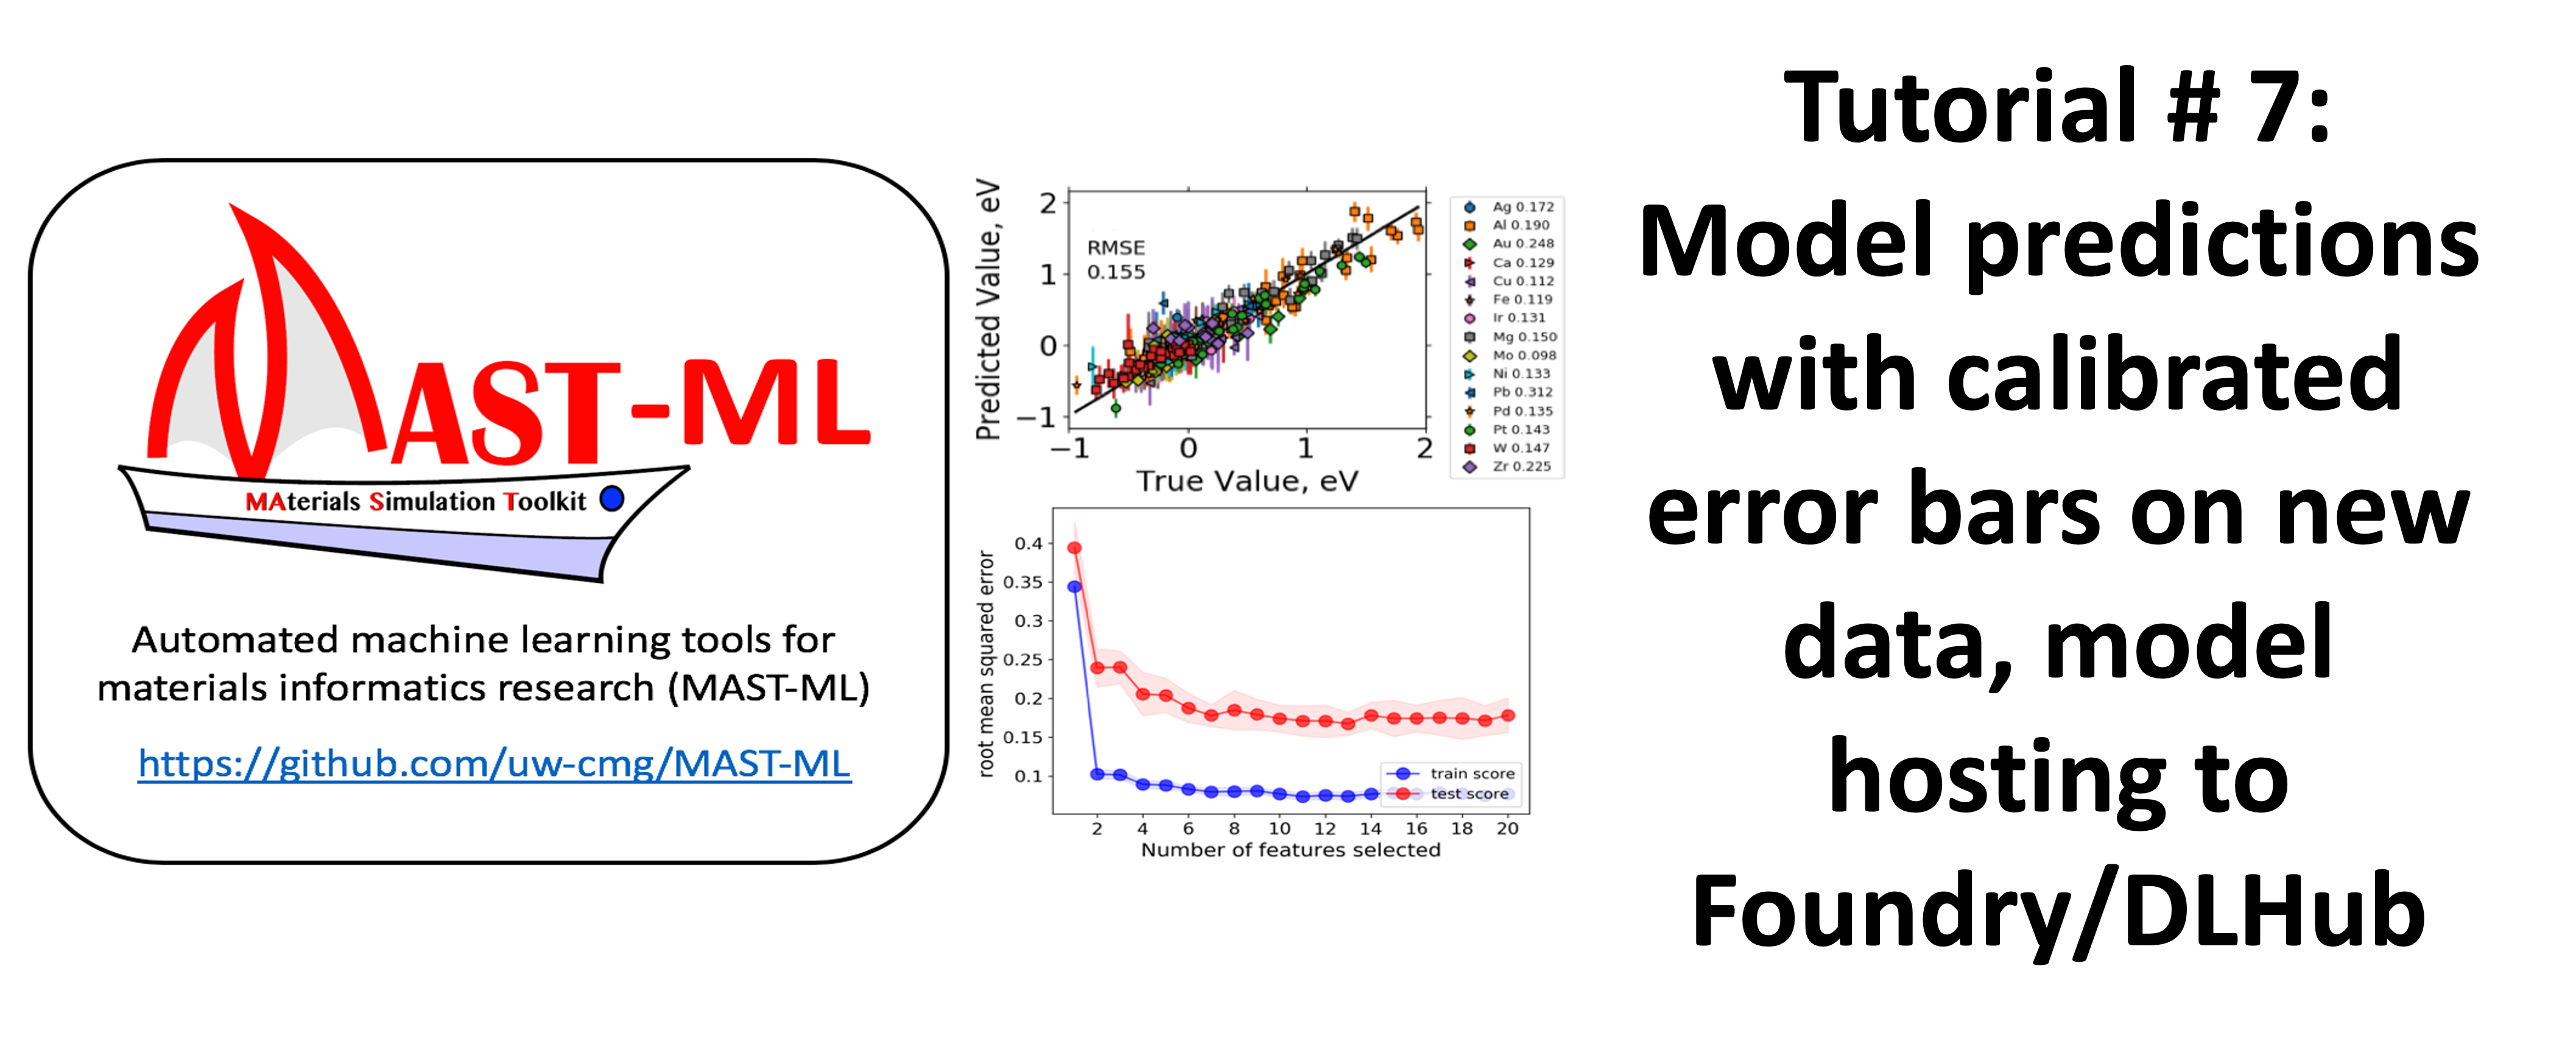

# Welcome to the seventh MAST-ML tutorial notebook, model predictions with calibrated error bars on new data!

## In this notebook, we will learn about how MAST-ML can be used to:

1. [Set up MAST-ML on Colab and begin session](#task1)
2. [Fit a model and use it to predict on new data](#task2)
3. [Use our model to predict on new data using only composition as input](#task3)
4. [Use nested CV to obtain error bar recalibration parameters and get predictions with calibrated error bars](#task4)
5. [Host our model on Foundry/DLHub and use it to get predictions with calibrated error bars](#task5)

## Task 1: Set up MAST-ML on Colab and begin session <a name="task1"></a>

If you are working on Google Colab and need to install MAST-ML, 
begin by pip installing MAST-ML to the Colab session
and install the needed dependencies:

In [ ]:
!pip install mastml

In [ ]:
!pip install pyyaml==5.4.1

Sync your Google drive to Colab so that we can save MAST-ML results to our Google
Drive. If we save to the Colab session, the data will be deleted when the session 
ends.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Here we import the MAST-ML modules used in this tutorial

In [1]:
from mastml.mastml import Mastml
from mastml.datasets import LocalDatasets
from mastml.preprocessing import SklearnPreprocessor
from mastml.feature_generators import ElementalFeatureGenerator
from mastml.feature_selectors import EnsembleModelFeatureSelector
from mastml.models import SklearnModel
from mastml.data_splitters import SklearnDataSplitter, NoSplit
from mastml.mastml_predictor import make_prediction
import mastml
import os
import shutil
import pandas as pd
try:
    data_path = os.path.join(mastml.__path__._path[0], 'data')
except:
    data_path = os.path.join(mastml.__path__[0], 'data')

Here, we set the name of the savepath to save MAST-ML results to, and initialize
our MAST-ML run

When the above command is run, a new folder with the name designated SAVEPATH is created.
This is where all of the output for the current MAST-ML run will be saved to.
Note that you can perform multiple runs with the same folder name, and the current datetime
will be appended to the name so that no data is lost or overwritten.

In [2]:
SAVEPATH = 'drive/MyDrive/MASTML_tutorial_7_ModelPredictions_with_CalibratedErrorBars'

mastml_instance = Mastml(savepath=SAVEPATH)
savepath = mastml_instance.get_savepath

drive/MyDrive/MASTML_tutorial_7_ModelPredictions_with_CalibratedErrorBars not empty. Renaming...


## Task 2: Fit a model and use it to predict on new data <a name="task2"></a>

In this tutorial, we will again use the diffusion dataset that we examined in the 
previous tutorial. Here, we use the LocalDatasets module to load in the diffusion dataset. 

In [3]:
target = 'E_regression'

extra_columns = ['Material compositions 1', 'Material compositions 2', 'Material compositions joined']

d = LocalDatasets(file_path=data_path+'/diffusion_data_nofeatures.xlsx', 
                  target=target, 
                  extra_columns=extra_columns, 
                  group_column='Material compositions 1',
                  testdata_columns=None,
                  as_frame=True)

# Load the data with the load_data() method
data_dict = d.load_data()

# Let's assign each data object to its respective name
X = data_dict['X']
y = data_dict['y']
X_extra = data_dict['X_extra']
groups = data_dict['groups']
X_testdata = data_dict['X_testdata']

We need to featurize the data with elemental features prior to running a fit

In [4]:
X, y = ElementalFeatureGenerator(composition_df=X_extra['Material compositions joined'], 
                                 feature_types=['composition_avg', 'arithmetic_avg', 'max', 'min', 'difference'], 
                                 remove_constant_columns=True).evaluate(X=X, y=y, savepath=savepath, make_new_dir=True)

Dropping 5/440 generated columns due to missing values


Here, we define the preprocessor, model, metrics and feature selector to use in our run

In [5]:
preprocessor = SklearnPreprocessor(preprocessor='StandardScaler', as_frame=True)

model_rf = SklearnModel(model='RandomForestRegressor', n_estimators=150)

metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']

selector = EnsembleModelFeatureSelector(model=model_rf, n_features_to_select=20)
X_select = selector.evaluate(X=X, y=y, savepath=savepath, make_new_dir=False)

In [31]:
splitter = NoSplit()

splitter.evaluate(X=X_select,
                  y=y, 
                  models=[model_rf],
                  mastml=mastml_instance,
                  preprocessor=preprocessor,
                  metrics=metrics,
                  plots=['Scatter', 'Histogram', 'Error'],
                  savepath=savepath,
                  X_extra=X_extra,
                  verbosity=3)

We can see from the parity plot that we have a low error, in this case an RMSE of 0.069 eV, because we used all of the data in the fit. Using all of your training data to create a final, "best" model given the data you have is common practice, and here we will use this model trained on our full diffusion database to show how you can make predictions on new data.

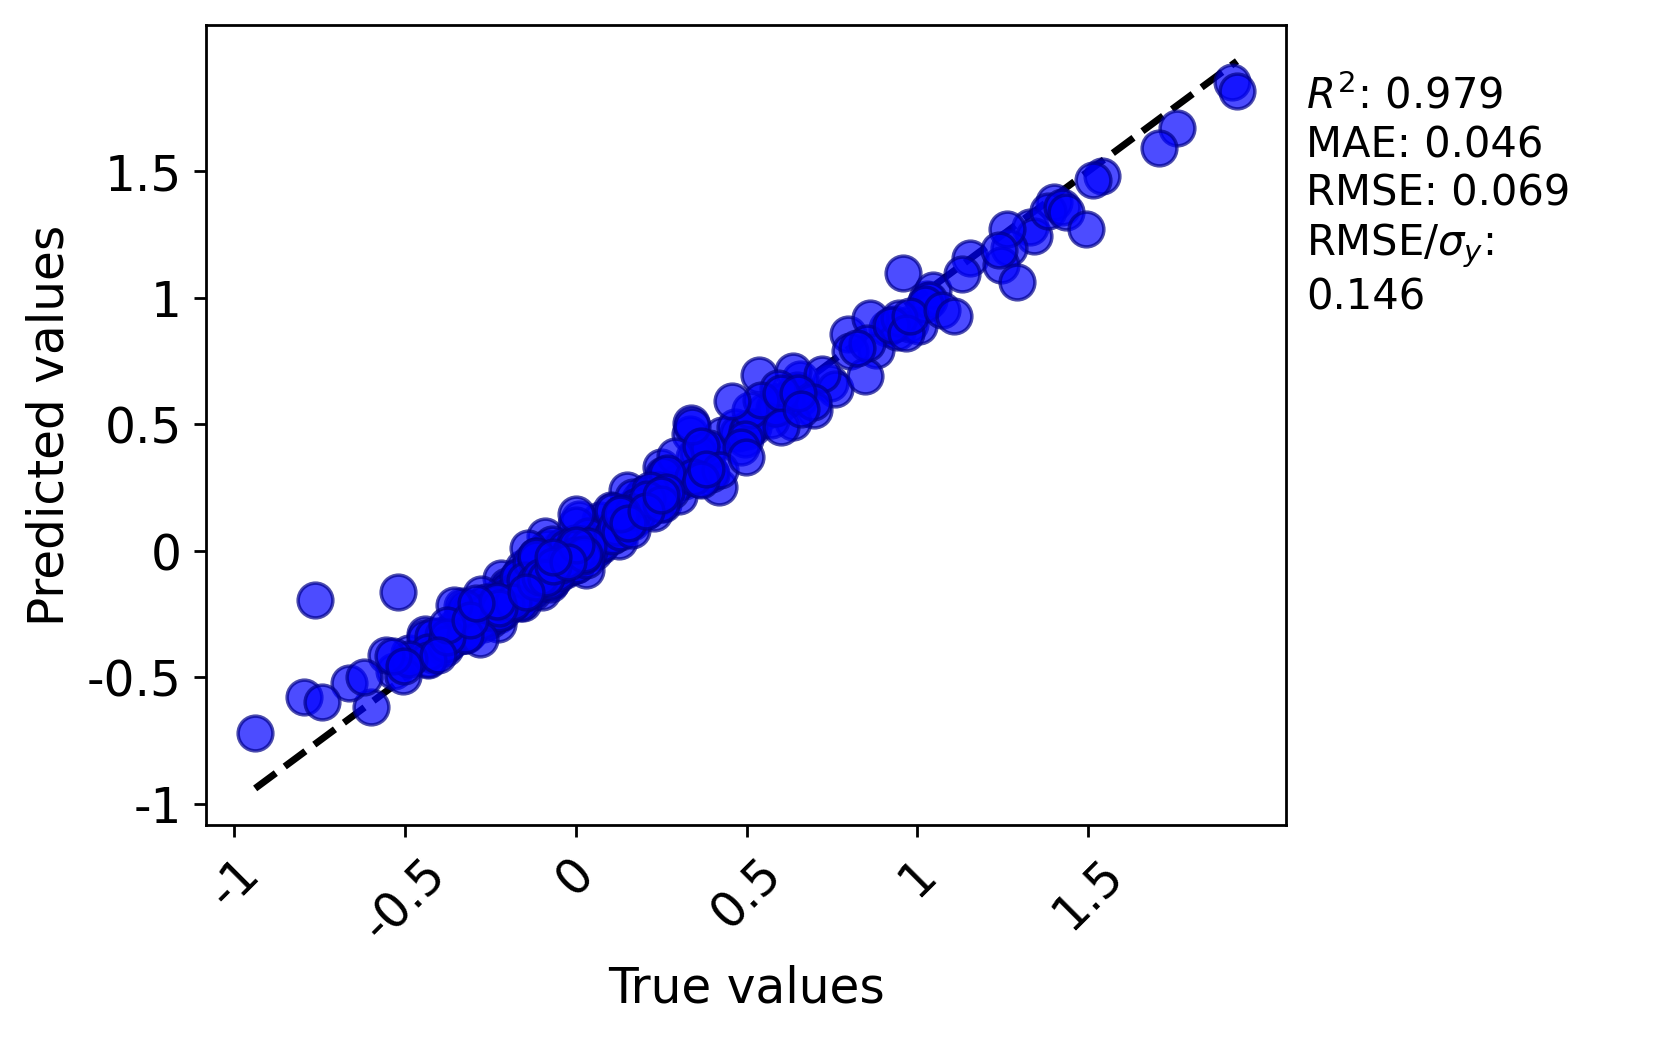

As a first example, let's suppose that we have our test data we want to predict already featurized. While this situation isn't common for models like our current one that are built from a large number of elemental features, it is common for models using a handful of features like composition fractions or processing variables like sintering time and temperature which are readily known.

Let's separate out our diffusion barriers for materials with Ag as a host. There are 11 values, and we can see we have our set of 20 elemental features in raw (unstandardized) form:

In [7]:
X_Ag = X_select[X_extra['Material compositions 1']== 'Ag']
X_Ag

,NdUnfilled_min_value,MendeleevNumber_arithmetic_average,MendeleevNumber_composition_average,MeltingT_difference,NdUnfilled_composition_average,MendeleevNumber_max_value,BCCmagmom_min_value,NdUnfilled_arithmetic_average,BCCvolume_padiff_difference,ICSDVolume_min_value,HeatVaporization_max_value,ThermalExpansionCoefficient_difference,BCCenergy_pa_max_value,AtomicVolume_difference,IonicRadii_arithmetic_average,BCCenergy_pa_min_value,HHIr_min_value,AtomicRadii_arithmetic_average,ElasticModulus_difference,IonicRadii_composition_average
0,0.0,65.0,65.0,0.00,0.0,65.0,0.000000,0.0,0.0,17.0,250.63,0.0,-2.719979,0.000000,1.150,-2.719979,1400.0,1.4440,0.0,1.150
1,3.0,61.5,61.5,533.07,1.5,65.0,1.684037,1.5,0.0,11.1,373.30,5.9,-2.719979,6.079787,0.900,-2.719979,1400.0,1.3485,128.0,0.900
2,5.0,57.0,57.0,945.07,2.5,65.0,0.000000,2.5,0.0,12.0,339.50,14.0,-2.719979,4.982710,0.885,-2.719979,1400.0,1.3465,179.0,0.885
3,0.0,64.5,64.5,122.84,0.0,65.0,0.000000,0.0,0.0,11.8,300.50,2.4,-2.719979,5.245706,0.940,-2.719979,1400.0,1.3610,44.0,0.940
4,4.0,60.0,60.0,576.07,2.0,65.0,2.110663,2.0,0.0,11.7,349.50,7.1,-2.719979,5.298283,0.850,-2.719979,1400.0,1.3425,131.0,0.850
5,5.0,58.5,58.5,284.07,2.5,65.0,0.818573,2.5,0.0,12.2,250.63,2.8,-2.719979,4.862943,0.910,-2.719979,1400.0,1.3420,118.0,0.910
6,2.0,63.0,63.0,493.07,1.0,65.0,0.064567,1.0,0.0,10.8,377.50,5.5,-2.719979,6.134364,0.920,-2.719979,1400.0,1.3450,128.0,0.920
7,9.0,38.0,38.0,579.07,4.5,65.0,0.000000,4.5,0.0,17.0,304.80,8.9,-2.719979,7.933663,0.950,-2.719979,1400.0,1.5250,0.0,0.950
8,8.0,54.0,54.0,706.07,4.0,65.0,0.000000,4.0,0.0,17.0,425.20,10.3,-2.719979,0.560669,0.880,-2.719979,1400.0,1.4460,30.0,0.880
9,7.0,55.5,55.5,948.07,3.5,65.0,0.000000,3.5,0.0,13.8,446.70,10.5,-2.719979,3.230750,0.845,-2.719979,1400.0,1.3825,49.0,0.845


To make predictions on new data, we are going to need two files: our saved model and our saved preprocessor from our full fit run. 

In [32]:
path_fullfit = splitter.splitdirs[0]
model_path = os.path.join(path_fullfit, 'RandomForestRegressor.pkl')
preprocessor_path = os.path.join(path_fullfit, 'StandardScaler.pkl')

To make predictions, we need to call the mastml_predictor.make_prediction() function. 

This function takes multiple input parameters, but for now all we need is the X_test data (given as a pandas dataframe or path to .xlsx or .csv file), the model file and preprocessor file:

In [33]:
pred_df = make_prediction(X_test=X_Ag, 
                          model=model_path, 
                          preprocessor=preprocessor_path)
pred_df

,y_pred,y_err
0,0.002001,0.035147
1,0.057606,0.195500
2,0.284088,0.115451
3,-0.020270,0.110821
4,0.294748,0.114599
5,0.192398,0.124440
6,0.200919,0.130988
7,0.036791,0.115988
8,0.190392,0.159109
9,0.361965,0.274729


We can see from the resulting dataframe that we have predicted values (y_pred) and error bars (y_err) for each value of our test data. The error bars are provided automatically even if no recalibration parameters are given, assuming the model type (here, Random forest) supports generation of error bars. Therefore, these error bars are not calibrated. If a model like linear regression or kernel ridge was given instead, then just a column of predictions would be returned.

It can be a little difficult to tell which test data point is which, so here we will show how to append extra column information to the prediction function to have a more informative output. Here, we get the extra columns associated with our test data and pass them into the prediction function using the X_test_extra parameter.

In [10]:
X_extra_Ag = X_extra[X_extra['Material compositions 1']== 'Ag']

In [34]:
pred_df = make_prediction(X_test=X_Ag, 
                          X_test_extra=X_extra_Ag, 
                          model=model_path, 
                          preprocessor=preprocessor_path)
pred_df

,y_pred,y_err,Material compositions 1,Material compositions 2,Material compositions joined
0,0.002001,0.035147,Ag,Ag,AgAg
1,0.057606,0.195500,Ag,Co,AgCo
2,0.284088,0.115451,Ag,Cr,AgCr
3,-0.020270,0.110821,Ag,Cu,AgCu
4,0.294748,0.114599,Ag,Fe,AgFe
5,0.192398,0.124440,Ag,Mn,AgMn
6,0.200919,0.130988,Ag,Ni,AgNi
7,0.036791,0.115988,Ag,Sc,AgSc
8,0.190392,0.159109,Ag,Ti,AgTi
9,0.361965,0.274729,Ag,V,AgV


We can see that with the extra information appended to our output dataframe, it is easier to see which test data points correspond to the specific predictions

## Task 3: Use our model to predict on new data using only composition as input<a name="task3"></a>

Now, let's consider the case where you enumerate a set of material compositions to test, but you haven't featurized them. This is a common use-case for making predictions on new materials using a model trained on a large set of elemental features. Here, our input test data is just a dataframe of material compositions:

In [12]:
X_test_Ag_nofeatures = pd.DataFrame(X_extra_Ag['Material compositions joined'])
X_test_Ag_nofeatures

,Material compositions joined
0,AgAg
1,AgCo
2,AgCr
3,AgCu
4,AgFe
5,AgMn
6,AgNi
7,AgSc
8,AgTi
9,AgV


Now, we need to pass information to the predictor about how to perform the featurization, and which features should be kept to make the prediction. To do this, we:

Set featurize=True so it knows that featurization needs to occur. 

Set featurizer = 'ElementalFeatureGenerator', the class name of the featurizer to use. 

Set featurizer_on = 'Material compositions joined', the column name containing the information needed to make the features (here, the material compositions)

Pass features_to_keep a list of features used in the model. For our model, we can get these features from the selected_features.txt file in our save directory from when we ran feature selection prior to our full fit

Finally, we also need to pass any required key-value pairs for the featurizer. In our case of using ElementalFeatureGenerator, we need to pass the value for composition_df, which is X_test_Ag_nofeatures, our dataframe of compositions to featurize

In [35]:
features_to_keep = list()
with open(os.path.join(savepath,'selected_features.txt'), 'r') as f:
    lines = f.readlines()
    for line in lines:
        features_to_keep.append(line.strip())
features_to_keep

['NdUnfilled_min_value',
 'MendeleevNumber_arithmetic_average',
 'MendeleevNumber_composition_average',
 'MeltingT_difference',
 'NdUnfilled_composition_average',
 'MendeleevNumber_max_value',
 'BCCmagmom_min_value',
 'NdUnfilled_arithmetic_average',
 'BCCvolume_padiff_difference',
 'ICSDVolume_min_value',
 'HeatVaporization_max_value',
 'ThermalExpansionCoefficient_difference',
 'BCCenergy_pa_max_value',
 'AtomicVolume_difference',
 'IonicRadii_arithmetic_average',
 'BCCenergy_pa_min_value',
 'HHIr_min_value',
 'AtomicRadii_arithmetic_average',
 'ElasticModulus_difference',
 'IonicRadii_composition_average']

In [36]:
pred_df = make_prediction(X_test=X_test_Ag_nofeatures, 
                          X_test_extra=X_extra_Ag, 
                          model=model_path, 
                          preprocessor=preprocessor_path,
                          featurize=True,
                          featurizer='ElementalFeatureGenerator',
                          featurize_on='Material compositions joined',
                          features_to_keep=features_to_keep,
                          composition_df=X_test_Ag_nofeatures['Material compositions joined'])
pred_df

Dropping 5/440 generated columns due to missing values


,y_pred,y_err,Material compositions 1,Material compositions 2,Material compositions joined
0,0.002001,0.035147,Ag,Ag,AgAg
1,0.057606,0.195500,Ag,Co,AgCo
2,0.284088,0.115451,Ag,Cr,AgCr
3,-0.020270,0.110821,Ag,Cu,AgCu
4,0.294748,0.114599,Ag,Fe,AgFe
5,0.192398,0.124440,Ag,Mn,AgMn
6,0.200919,0.130988,Ag,Ni,AgNi
7,0.036791,0.115988,Ag,Sc,AgSc
8,0.190392,0.159109,Ag,Ti,AgTi
9,0.361965,0.274729,Ag,V,AgV


As we can see, we get the same predictions as before, but this time the featurization step was done internally prior to making the prediction. This is useful for the case if you want to enumerate a large composition space of perhaps thousands of test compounds. As an example, here let's just loop over all pairs of elements in the periodic table and output the resulting predictions:

In [ ]:
elements = ['H', 'He', 
            'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne',
           'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar',
           'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr',
           'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe',
           'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn']
comps_to_predict = list()
for el in elements:
    for el2 in elements:
        comps_to_predict.append(el+el2)
X_periodictable = pd.DataFrame(comps_to_predict, columns=['Material compositions'])
X_periodictable

We can see that this results in 7396 host-impurity pairs to predict. As before, let's predict the migration barrier values for all of these materials, performing featurization along the way. Note that running this many predictions will likely take a couple minutes.

In [ ]:
pred_df_full = make_prediction(X_test=X_periodictable, 
                          X_test_extra=X_periodictable, 
                          model=model_path, 
                          preprocessor=preprocessor_path,
                          featurize=True,
                          featurizer='ElementalFeatureGenerator',
                          featurize_on='Material compositions',
                          features_to_keep=features_to_keep,
                          composition_df=X_periodictable['Material compositions'])
pred_df_full

## Task 4: Use nested CV to obtain error bar recalibration parameters and get predictions with calibrated error bars<a name="task4"></a>

Here, we want to obtain calibration parameters to have more accurate error bars. We follow the same procedure as shown in Tutorial 6. Note that for the purposes of this tutorial we will only perform a single iteration of nested 5-fold CV, but in practice you will likely want to perform many more iterations for more sampling and more accurate results

In [27]:
splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=1, n_splits=5)
splitter.evaluate(X=X_select,
                  y=y, 
                  models=[model_rf],
                  mastml=mastml_instance,
                  preprocessor=preprocessor,
                  metrics=metrics,
                  plots=['Error'],
                  savepath=savepath,
                  X_extra=X_extra,
                  nested_CV=True,
                  error_method='stdev_weak_learners', 
                  recalibrate_errors=True,
                  verbosity=2,
                  parallel_run=True)

To make predictions on new data with calibrated error bars, we follow the same procedure as above, except this time we need to include the path to the file containing the calibration parameter values.

In [28]:
path = splitter.splitdirs[0]
calibration_file_path = os.path.join(path, 'recalibration_parameters_average_test.csv')

Let's first have a quick look at an assessment of the uncalibrated vs. calibrated errors on the left-out data:

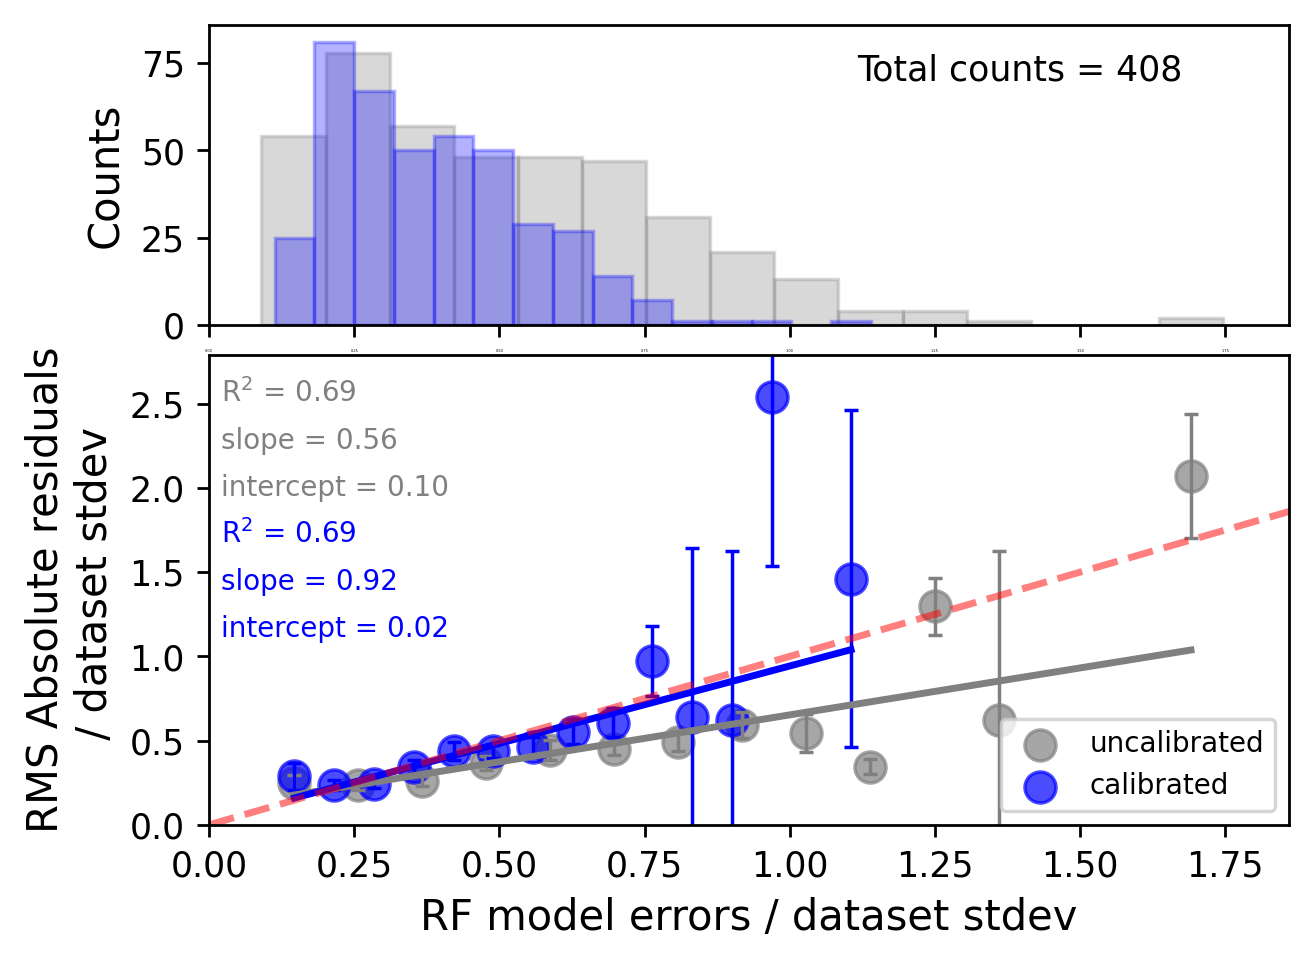

Even with one iteration of nested CV, the results still look quite good! The slope of the RvE plot is closer to 1 and the intercept is closer to 0 after calibration. This assessment can give us some confidence that our calibrated error bars should be more reliable than our previous uncalibrated error bars. The RvE plot also shows that the uncalibrated errors were likely an overestimation of the real error bars. So, when we run our prediction with the calibrated error bars, we should see errors that are of lower magnitude than what we obtained above

In [37]:
pred_df_cal = make_prediction(X_test=X_test_Ag_nofeatures, 
                          X_test_extra=X_extra_Ag, 
                          model=model_path, 
                          preprocessor=preprocessor_path,
                          calibration_file=calibration_file_path,
                          featurize=True,
                          featurizer='ElementalFeatureGenerator',
                          featurize_on='Material compositions joined',
                          features_to_keep=features_to_keep,
                          composition_df=X_test_Ag_nofeatures['Material compositions joined'])
pred_df_cal

Dropping 5/440 generated columns due to missing values


,y_pred,y_err,Material compositions 1,Material compositions 2,Material compositions joined
0,0.002001,0.062598,Ag,Ag,AgAg
1,0.057606,0.155864,Ag,Co,AgCo
2,0.284088,0.109305,Ag,Cr,AgCr
3,-0.020270,0.106612,Ag,Cu,AgCu
4,0.294748,0.108809,Ag,Fe,AgFe
5,0.192398,0.114533,Ag,Mn,AgMn
6,0.200919,0.118342,Ag,Ni,AgNi
7,0.036791,0.109617,Ag,Sc,AgSc
8,0.190392,0.134698,Ag,Ti,AgTi
9,0.361965,0.201946,Ag,V,AgV


Indeed, we can see that the error bars when we included the calibration are generally smaller than our original, uncalibrated values:

In [30]:
print('Uncalibrated', pred_df['y_err'])
print('Calibrated', pred_df_cal['y_err'])

Uncalibrated 0     0.020715
1     0.191695
2     0.159843
3     0.117183
4     0.182888
5     0.107005
6     0.147034
7     0.096194
8     0.171955
9     0.237873
10    0.088916
Name: y_err, dtype: float64
Calibrated 0     0.054204
1     0.153650
2     0.135125
3     0.110312
4     0.148528
5     0.104393
6     0.127674
7     0.098104
8     0.142169
9     0.180509
10    0.093871
Name: y_err, dtype: float64


## Task 5: Host our model on Foundry/DLHub and use it to get predictions with calibrated error bars<a name="task5"></a>

The final step of the ML model generation process is dissemination to a broader community of users. Once you are happy with the performance of your model, you can upload it to the Foundry/DLHub model repository, where it will be publicly available and usable by anyone with just a couple lines of python code. 

First, we need to specify the paths of the model, preprocessor, training data and calibration file we wish to upload:

In [40]:
model_path = os.path.join(path_fullfit, 'RandomForestRegressor.pkl')
training_data_path = os.path.join(path_fullfit, 'X_train.csv')
preprocessor_path = os.path.join(path_fullfit, 'StandardScaler.pkl')
calibration_file_path = os.path.join(path, 'recalibration_parameters_average_test.csv')

shutil.copy(model_path, os.path.join(os.getcwd(), 'model.pkl'))
shutil.copy(training_data_path, os.path.join(os.getcwd(), 'X_train.csv'))
shutil.copy(preprocessor_path, os.path.join(os.getcwd(), 'preprocessor.pkl'))
shutil.copy(calibration_file_path, os.path.join(os.getcwd(), 'calibration_file.csv'))

'/Users/ryanjacobs/PycharmProjects/mastml_dev/examples/calibration_file.csv'

Now, we need to create the relevant metadata to describe our model, as well as its inputs and outputs. For our purposes here, we will be hosting a general python container which calls MAST-ML's model prediction function. Rather than using the make_prediction function from earlier, we use the make_prediction_dlhub function. Below is a template we will use to upload our model. Update the following all-caps fields below:

DATE : The current date in YYYY-MM-DD format

MODEL_NAME : Name of your model. Here, we will just use "MASTML_Tutorial_Model"

MY_NAME : Your name as Last Name, First Name. Here, we will just use "MASTML , User"

MY_AFFILIATION : Your affiliation. Here, we will just use "Planet_Earth"

MY_USERNAME : Your Globus user name. See below for information on signing up for a Globus account if this is your first time.

If you want to upload multiple versions of a model, change the model name with a version modifier

If this is your first time uploading a model, you will need to sign up for a Globus account. More information on getting started can be found in the Foundry documentation here: https://ai-materials-and-chemistry.gitbook.io/foundry/v/docs/#globus

In [45]:
from dlhub_sdk.models.servables.python import PythonStaticMethodModel
from mastml.mastml_predictor import make_prediction_dlhub
from mastml.mastml import write_requirements
import mastml
import os

########################################
# CHANGE THESE
DATE = '2022-10-18_v2'
MODEL_NAME = 'MASTML_Tutorial_Model'
MY_NAME = 'Jacobs, Ryan'
MY_AFFILIATION = "University of Wisconsin-Madison"
MY_USERNAME = 'rjacobs3_wisc'
########################################

model = PythonStaticMethodModel.from_function_pointer(make_prediction_dlhub)

model_name = MODEL_NAME+'_'+DATE
model.set_name(model_name)
model.set_title(MODEL_NAME)
model.set_publication_year('2022')
model.set_version("1.0")
model.set_domains(['materials science'])

model.set_creators([MY_NAME], [[MY_AFFILIATION]])

model.set_inputs(data_type='dict',
                 description='Dict containing input parameters for mastml.mastml_predictor make_prediction_dlhub function',
                 properties={"X_test": {"type": 'python object', 
                                        "python_type": "pandas.DataFrame",
                                       "description":'dataframe of featurized test data to be used to make prediction (if featurize=False), or dataframe of compositions or other input needed for featurization (if featurize=True)'},
                           "X_test_extra": {"type": 'python object', 
                                            "python_type": "pandas.DataFrame",
                                            "description":'dataframe containing the extra data associated with X_test'},
                           "featurize": {"type": 'boolean',
                                        "description": 'whether or not featurization of the provided X_test data needs to be performed'},
                           "featurizer": {"type": 'string',
                                         "description": 'string denoting a mastml.feature_generators class, e.g., ElementalFeatureGenerator'},
                           "featurize_on": {"type": 'string',
                                           "description": 'string of column name in X_test to perform featurization on'},
                           "composition_df": {"type": 'python object', 
                                              "python_type": "pandas.DataFrame",
                                             "description": 'additional argument needed for ElementalFeatureGenerator. The dataframe to perform featurization on'}})

model.set_outputs("python object", 
                  'pandas dataframe containing predicted values (y_pred) and uncertainties (y_err), if applicable',
                  python_type="pandas.DataFrame")

# Removed cached files
if os.path.exists(os.path.join(os.getcwd(), 'mastml/__pycache__')):
    shutil.rmtree(os.path.join(os.getcwd(), 'mastml/__pycache__'))

# Note the file names for the designated files below MUST have these names
# X_train and calibration_file can be either .xlsx or .csv

# Note that the submitted files MUST be in the current working directory from which this notebook is run
# in order for the remote container to be built properly

# Required:
model.add_file('model.pkl')

# Optional:
model.add_file('preprocessor.pkl') 
model.add_file('X_train.csv')
model.add_file('calibration_file.csv')

# Write a requirements.txt file to the present directory
write_requirements()
model.add_file('requirements.txt')

PythonStaticMethodModel(dlhub=DLHubMetadata(version='1.0.0', domains=['materials science'], visible_to=['public'], name='MASTML_Tutorial_Model_2022-10-18_v2', files={'other': ['model.pkl', 'preprocessor.pkl', 'X_train.csv', 'calibration_file.csv', 'requirements.txt']}, dependencies={}, test=None, type='servable'), datacite=Datacite(identifier=DataciteIdentifier(identifier='10.datacite/placeholder', identifierType=<DataciteIdentifierType.DOI: 'DOI'>), creators=[DataciteCreator(creatorName=None, nameIdentifiers=[], affiliations=['University of Wisconsin-Madison'], familyName='Jacobs', givenName='Ryan')], titles=[DataciteTitle(title='MASTML_Tutorial_Model', type=None, lang=None)], publisher='DLHub', publicationYear='2022', subjects=[], resourceType={'resourceTypeGeneral': 'InteractiveResource'}, contributors=[], descriptions=[], language=None, alternateIdentifiers=[], relatedIdentifiers=[], rightsList=[], fundingReferences=[], version='1.0'), servable=ServableMetadata(type='Python static 

Import and instantiate DLHubClient

In [46]:
from dlhub_sdk.client import DLHubClient
dl = DLHubClient()

Publish the model!

In [47]:
dl.publish_servable(model)

'2371c51c-9e49-45e9-b5b9-c2ded8da1491'

It will take a few minutes for the model container to be built and accessible. You can query the list of available servables using your DLHub username.

You can also look at the list of available servables online here: https://acdc.alcf.anl.gov/dlhub/?q=*

In [50]:
servables = dl.list_servables()
for servable in servables:
    if MY_USERNAME in servable:
        print(servable)

rjacobs3_wisc/thermal_conductivity_predictor_gbr_v2
rjacobs3_wisc/thermal_conductivity_predictor_gbr
rjacobs3_wisc/Test5b_mastml_v2
rjacobs3_wisc/Test5b_mastml
rjacobs3_wisc/Test5_mastml
rjacobs3_wisc/Test3c_dbtt
rjacobs3_wisc/Test3b_dbtt
rjacobs3_wisc/Test3_dbtt
rjacobs3_wisc/Test2_sklearn_v2
rjacobs3_wisc/Test2_sklearn
rjacobs3_wisc/Test1_numpy_v2
rjacobs3_wisc/Test1_numpy
rjacobs3_wisc/superconductor_Tc_predictor_gbr
rjacobs3_wisc/steel_strength_predictor_gbr_v2
rjacobs3_wisc/steel_strength_predictor_gbr
rjacobs3_wisc/static_method_v4
rjacobs3_wisc/static_method_v3
rjacobs3_wisc/static_method_v2
rjacobs3_wisc/static_method
rjacobs3_wisc/solarpv_hsegap_GBR
rjacobs3_wisc/Semiconductor_defect_levels_predictor_2022-03-07_v2
rjacobs3_wisc/Semiconductor_defect_levels_predictor_2022-03-07
rjacobs3_wisc/Semiconductor_defect_levels_predictor_2022-03-04_v4
rjacobs3_wisc/Semiconductor_defect_levels_predictor_2022-03-04_v3
rjacobs3_wisc/Semiconductor_defect_levels_predictor_2022-03-04_v2
rjacob

Once you see your servable appear, we can try using it!

The parameters we pass are very similar to our previous predictions, but the two main differences are the parameters are passed as a dictionary and we don't have to specify the model and preprocessor information, because that is already in the python container we are using.

Note that this next cell is using the model we uploaded to Foundry/DLHub, running the model remotely in the cloud, and relaying the results back to us in the notebook!

In [49]:
from dlhub_sdk.client import DLHubClient

input_dict = {'X_test': X_test_Ag_nofeatures,
              'X_test_extra': X_extra_Ag,
             'featurize': True,
             'featurizer': 'ElementalFeatureGenerator',
             'featurize_on': 'Material compositions joined',
              'composition_df': X_test_Ag_nofeatures['Material compositions joined']
             }
#dlhub_servable = MY_USERNAME+'/'+model_name
dlhub_servable = 'rjacobs3_wisc/MASTML_Tutorial_Model_2022-10-18'
pred_df = DLHubClient().run(name=dlhub_servable, inputs=input_dict, debug=False, validate_input=False)
pred_df

,y_pred,y_err,Material compositions 1,Material compositions 2,Material compositions joined
0,0.002001,0.062598,Ag,Ag,AgAg
1,0.057606,0.155864,Ag,Co,AgCo
2,0.284088,0.109305,Ag,Cr,AgCr
3,-0.020270,0.106612,Ag,Cu,AgCu
4,0.294748,0.108809,Ag,Fe,AgFe
5,0.192398,0.114533,Ag,Mn,AgMn
6,0.200919,0.118342,Ag,Ni,AgNi
7,0.036791,0.109617,Ag,Sc,AgSc
8,0.190392,0.134698,Ag,Ti,AgTi
9,0.361965,0.201946,Ag,V,AgV


You've now completed your seventh MAST-ML tutorial notebook! You've reached the end of the MAST-ML tutorial series.